In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import calinski_harabasz_score, confusion_matrix

from models.CAE import CAE
from models.VCAE import VCAE
from generate import sin_cos, arma, wind
from train import train
from utils import latent_space, choose_bottleneck, compute_distance_matrix

import hydra
from hydra.experimental import initialize, compose

torch.manual_seed(4444)
np.random.seed(4444)

# Create Dataset

In [2]:
with initialize(config_path="conf"):
    cfg = compose(config_name="config")

cfg_dataset, cfg_model, cfg_train = cfg.dataset, cfg.model, cfg.train

In [3]:
n_train, n_valid, n_test = cfg_dataset.n_train, cfg_dataset.n_valid, cfg_dataset.n_test
n = n_train+n_valid+n_test

length = cfg_model.length # each observation is a vector of size (1,length)

## Generate documents

In [4]:
#X = sin_cos(n, length)
#X = wind(num_elems=length)

X1 = arma(n//3, length, ar=[0, -0.5] , ma=[0, 0.1])
X2 = arma(n//3, length, ar=[0, 0, 0.7] , ma=[0, 0, 0.05])
X3 = arma(n//3, length, ar=[0, 0, 0, 0, -0.6] , ma=[0, 0, 0, 0, 0.2])
class1 = np.array([0]*(n//3), dtype=np.float32).reshape(n//3, 1, 1)
class2 = np.array([1]*(n//3), dtype=np.float32).reshape(n//3, 1, 1)
class3 = np.array([2]*(n//3), dtype=np.float32).reshape(n//3, 1, 1)
X1 = np.append(X1, class1, 2)
X2 = np.append(X2, class2, 2)
X3 = np.append(X3, class3, 2)

X = np.r_[X1,X2,X3]
Y = np.array([1]*len(X1) + [2]*len(X2) + [3]*len(X3))

idx = list(range(len(X)))
np.random.shuffle(idx)
X = X[idx]
Y = Y[idx]

X = torch.from_numpy(X)
print("shape of X:", X.shape)

X_train, X_valid, X_test = X[:n_train], X[n_train:n_train+n_valid], X[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y[:n_train], Y[n_train:n_train+n_valid], Y[n_train+n_valid:]
print("shape of X_train, X_valid, X_test:", X_train.shape, X_valid.shape, X_test.shape)

shape of X: torch.Size([1200, 1, 65])
shape of X_train, X_valid, X_test: torch.Size([1000, 1, 65]) torch.Size([100, 1, 65]) torch.Size([100, 1, 65])


# Model

In [5]:
model = CAE(cfg_model)

## Train

In [6]:
train_losses, valid_losses = train(model, cfg_train, X_train, X_valid)

EPOCH 10 train loss: 1.356708850711584, valid loss: 1.3349835574626923
epochs without improvement: 0

EPOCH 20 train loss: 1.2312047109007835, valid loss: 1.233161211013794
epochs without improvement: 0

EPOCH 30 train loss: 1.1216283775866032, valid loss: 1.1324407458305359
epochs without improvement: 0

EPOCH 40 train loss: 1.0406341310590506, valid loss: 1.068660855293274
epochs without improvement: 1

EPOCH 50 train loss: 0.9828153122216463, valid loss: 1.0007201433181763
epochs without improvement: 0

EPOCH 60 train loss: 0.9321891479194164, valid loss: 0.9576192498207092
epochs without improvement: 0

EPOCH 70 train loss: 0.8990869093686342, valid loss: 0.9274291098117828
epochs without improvement: 1

EPOCH 80 train loss: 0.8608299642801285, valid loss: 0.9151127636432648
epochs without improvement: 4

EPOCH 90 train loss: 0.8283205479383469, valid loss: 0.9052737653255463
epochs without improvement: 0

EPOCH 100 train loss: 0.8017758224159479, valid loss: 0.9121455550193787
epo

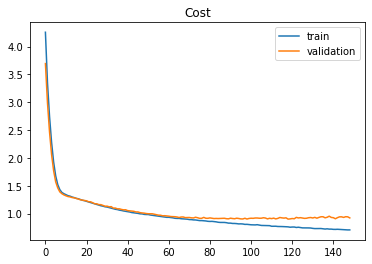

In [7]:
plt.title("Cost")
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="validation")
plt.legend()

## Load/Save model

In [8]:
#torch.save(model.state_dict(), "../saved_weights/vcae_kl0.25")
#model.load_state_dict(torch.load("../saved_weights/vcae_kl0.25"))

# Testing

## Average and std correlation

avg and std: 0.6507664835164833 0.10228944587229327

cor: 0.47641941391941384
cor: 0.7836538461538459
cor: 0.7036630036630036
cor: 0.7896062271062271


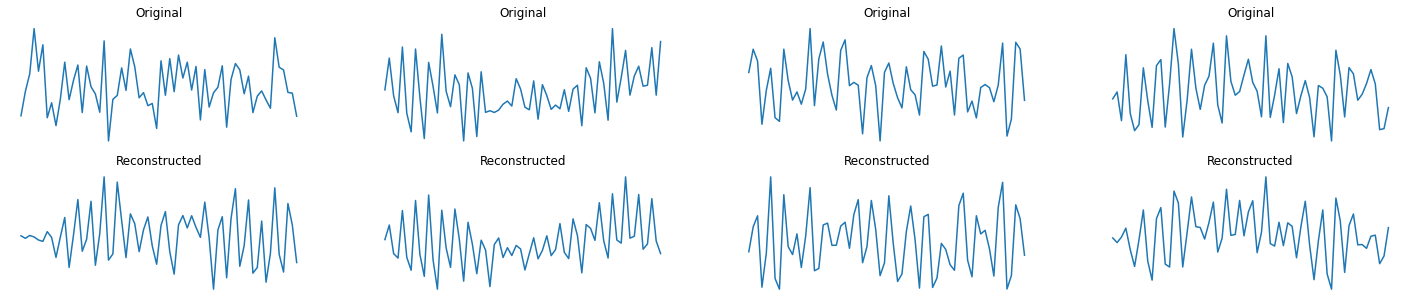

In [9]:
pred = model(X_test).detach().numpy()
inp = X_test[:,:,:-1]

# avg and std of cors
cors = [scipy.stats.spearmanr(pred[i,0], inp[i,0]).correlation for i in range(n_test)]
print("avg and std:", np.mean(cors), np.std(cors))
print()

# plots
n_plots = 4
start = n_plots*0

fig, axs = plt.subplots(nrows=2, ncols=n_plots, figsize=(25,5))
for i in range(n_plots):
    
    axs[0,i].axis("off")
    axs[0,i].set_title("Original")
    axs[0,i].plot(inp[start+i,0])

    axs[1,i].axis("off")
    axs[1,i].set_title("Reconstructed")
    axs[1,i].plot(pred[start+i,0])
    print("cor:", scipy.stats.spearmanr(pred[start+i,0], inp[start+i,0]).correlation)

Accuracy: 0.65


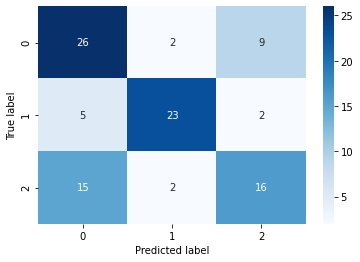

In [10]:
inp = X_test # data to perfom prediction
_, pred = model(inp, get_training=True)
probs = torch.nn.functional.softmax(pred)
pred = torch.argmax(probs, dim=1).detach().numpy()
real = inp[:,:,-1].flatten().long().detach().numpy()

cm = confusion_matrix(real, pred)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")

print("Accuracy:", np.sum(np.diag(cm))/inp.shape[0])

# Checking important filters

<AxesSubplot:>

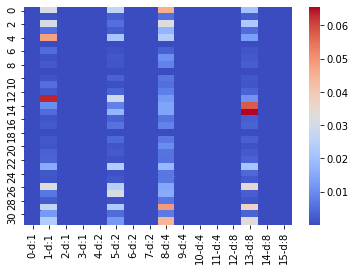

In [11]:
num_filter = 4*cfg_model.M
w_per_filter = cfg_model.length-cfg_model.Lf+1 # weights per filter
num_neurons = cfg_model.bottleneck_nn
M = cfg_model.M 

if isinstance(model, VCAE):
    num_neurons *= 2

w = np.array([[torch.mean(torch.abs(model.full1.weight[j,i*w_per_filter:(i+1)*w_per_filter])).item() for i in range(num_filter)] for j in range(num_neurons)])

x_axis_labels = [f"{i}-d:{2**(i//M)}" for i in range(w.shape[1])] # number of filter - d:dilatation
sns.heatmap(w, cmap="coolwarm", xticklabels=x_axis_labels) # y-axis => neuron of the bottleneck, x-axis => each position is one filter ordered by dilatation